In [3]:
### - import all the usual stuff - ###

import sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

# import module
import torch
from src.utils.comb import Comb3
import numpy as np
from scipy.signal import welch
from scipy.ndimage import uniform_filter1d
from tqdm import tqdm
import jax.numpy as jnp
import plotfancy as pf
pf.housestyle_rcparams()

from gwosc.datasets import event_gps

from ipywidgets import interactive_output, VBox, HBox, FloatSlider, Checkbox, FloatLogSlider, FloatRangeSlider, FloatText, IntSlider

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os, sys

from simulators.additive import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

True

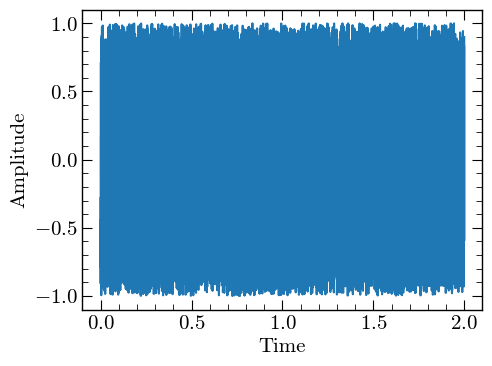

In [8]:
n_bins = 10000
white_noise = np.random.uniform(low=-1.0, high=1.0, size=n_bins)
white_noise_td = np.linspace(0,2,n_bins)

fig,ax1=pf.create_plot()
ax1.plot(white_noise_td,white_noise)
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
pf.fix_plot([ax1])

min 2381.988245950455, max 2499.7499999999995
Generating stochastic comb res 0.002000200020002, nf 8, f0 2381.988245950455, df 10.718815899686037


/data/tgh35/summer25/cam_venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/data/tgh35/summer25/cam_venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


True

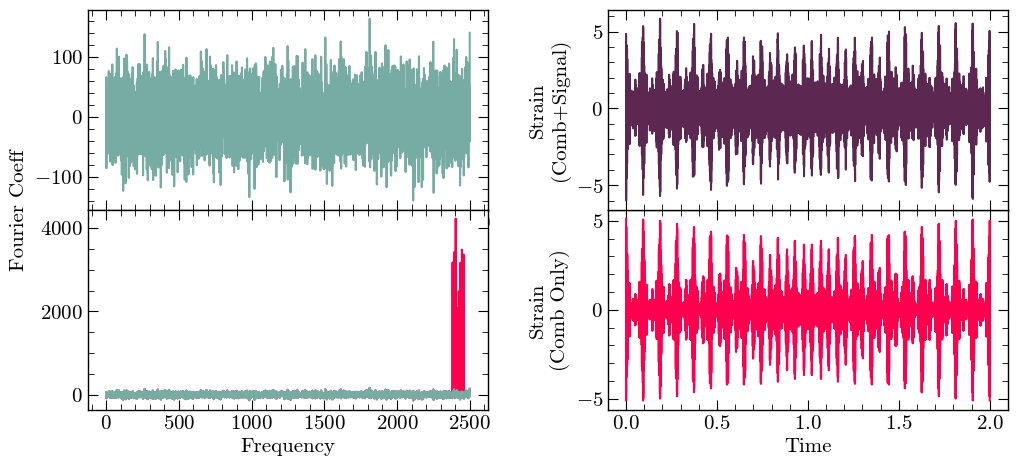

In [9]:
test = Comb3(white_noise,white_noise_td)

fig2, ax2 = pf.create_plot(size=(4,2))
ax2.plot(test.w_FD_freqs,test.w_FD_data, color='#77aca2')

ax3 = fig2.add_axes((0,-1,1,1), sharex=ax1)
ax3.plot(test.w_FD_freqs, test.i_FD_data, color='#ff004f')
ax3.plot(test.w_FD_freqs, test.w_FD_data, color='#77aca2')

ax3.set_xlabel('Frequency')
ax3.set_ylabel('Fourier Coeff')
ax3.yaxis.set_label_coords(-0.15,1)


ax4 = fig2.add_axes((1.3,-1,1,1))
ax4.set_xlabel('Time')
ax4.set_ylabel('Strain\n(Comb Only)')

ax4.plot(test.w_TD_times,test.i_TD_data_comb, color='#ff004f')

ax5 = fig2.add_axes((1.3,0,1,1), sharex=ax4)
plt.setp(ax5.get_xticklabels(), visible=False)
ax5.plot(test.w_TD_times,test.i_TD_data, color='#5C2751')
ax5.set_ylabel('Strain\n(Comb+Signal)')

pf.fix_plot([ax2,ax3,ax4,ax5])

In [ ]:
from models.online_norm import OnlineStandardizingLayer
from models.resnet_1d import ResidualNet

class Network_Comb(torch.nn.Module):
    def __init__(self, n_bins):
        super().__init__()
        self.online_norm = OnlineStandardizingLayer((n_bins,), use_average_std=True)
        self.net = ResidualNet(1, 1, 128) # 1 input channel, 1 output channel, 128 hidden features

    def epsilon(self, x):
        x = self.online_norm(x)
        x = self.net(x.unsqueeze(1)).squeeze(1)
        return x
    
    def epsilon(self, x):
        x = self.online_norm(x)
        x = self.net(x.unsqueeze(1)).squeeze(1)
        return x
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    def forward(self, x):

        data = x['xi']
        epsilon_real = x['epsilon']

        epsilon = self.epsilon(data)
        mask = ( x['ni'] != 0 )  
        squared_error = (epsilon - epsilon_real)**2                                                                    # [B, N_bins]
        l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
        return (l * mask.float()).sum() * 0.5

        
